In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
from livelossplot import PlotLosses
import tensorflow as tf
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
from scipy.linalg import block_diag
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils_highdim import *
tf.keras.backend.set_floatx('float32')

print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.15.0


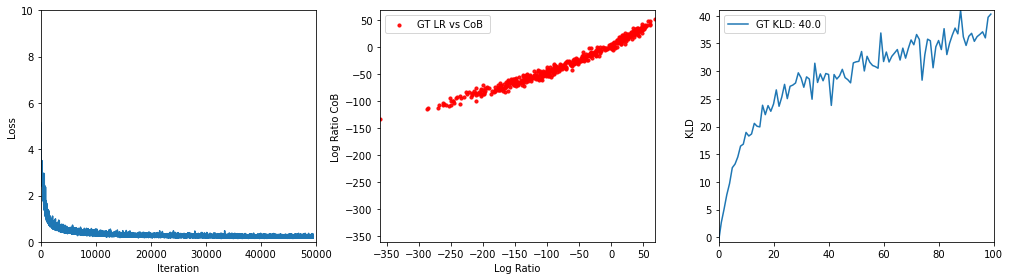

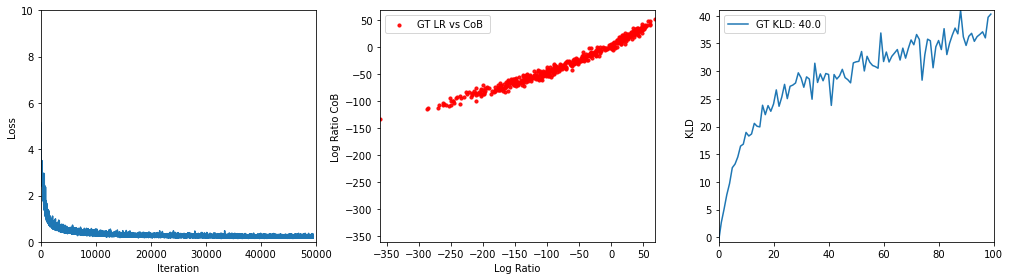

In [80]:
# %matplotlib widget

reset(4)
def get_rho_from_mi(mi, n_dims):
    """Get correlation coefficient from true mutual information"""
    x = (4 * mi) / n_dims
    return (1 - np.exp(-x)) ** 0.5  # correlation coefficient

n_dims = 160
mi = 40
rho = get_rho_from_mi(mi, n_dims)  # correlation coefficient
print(rho)
rhos = np.ones(n_dims // 2, dtype="float32") * rho


mu_1=np.zeros((n_dims), dtype="float32")
mu_2=np.zeros((n_dims), dtype="float32")
mu_3=np.zeros((n_dims), dtype="float32")

scale_p = block_diag(*[[[1, rho], [rho, 1]] for _ in range(n_dims // 2)])
scale_p = np.float32(scale_p)
scale_q = np.ones(n_dims, dtype="float32")
scale_m = 1*np.eye(n_dims, dtype="float32")

N=50000
deep=False

p, q, m, p_samples, q_samples, m_samples, m_dist = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
optim = get_optim(dloss,lr=1e-3) #,lr=5e-3,b1=.99

log_ratio_p_q, _, kld = get_gt_ratio_kl(p,q,m_samples)
_, kl_from_pq, _ = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples)

log_ratio_p_m = get_logits(m_samples,deep=deep, training=False)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


fig, [ax1,ax2,ax3] = plt.subplots(1, 3,figsize=(14,4))

line, = ax1.plot([0,1],[0,1])
kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(kl_gt))
x, y = np.random.random((2, 500))
[kl_gt] = sess.run([kld],feed_dict=feed_dict)
scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_xlim([0,N])
ax1.set_ylim([0,10])

ax2.set_xlabel("Log Ratio")
ax2.set_ylabel("Log Ratio CoB")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')


plt.tight_layout()
loss_store=[]
kld_store=[]
pbar = range(0,N)
for i in pbar:

    feed_dict = {}
    l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
    loss_store.append(l)
    if i%500==0:
        line.set_data(range(len(loss_store)), loss_store)
        xs, lpq, lpqm, kl_cob = sess.run([m_samples, log_ratio_p_q, log_ratio_p_m, kl_from_cob],feed_dict={})
        kld_store.append(kl_cob)
        cob = lpqm[:,0]-lpqm[:,1]
        scat.set_offsets(np.asarray([lpq,cob]).T)
        ax2.set_xlim( lpq.min(), lpq.max() )
        ax2.set_ylim( lpq.min(), lpq.max() )
        
        kld_line.set_data(range(len(kld_store)),kld_store)
        ax3.set_xlim( 0, len(kld_store) )
        ax3.set_ylim( min(kld_store), max(kld_store) )

        clear_output(wait=True)
        display(fig)


# sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)



    